# Michael Ha



# Conduct package imports


In [ ]:
import json

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from torch.optim import Adam
from torch.utils.data import DataLoader, TensorDataset, RandomSampler, SequentialSampler
!pip install transformers
from transformers import BertTokenizer, BertForSequenceClassification

# Check for CUDA availability

In [ ]:
print("CUDA available:", torch.cuda.is_available())
print("Number of GPUs:", torch.cuda.device_count())

CUDA available: False
Number of GPUs: 0


# Read the file

In [ ]:
df = pd.read_csv('Reviews.csv')

# Set the dataframe size to 50%


In [ ]:
df = df.sample(frac=0.5, replace=True).reset_index(drop=True)

# Drop null values and print out statistics


In [ ]:
df.dropna(inplace=True)
display(df.head())
display(df.tail())
print(f"\nPrint out shape:\n{df.shape}")

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,65502,B001EQ55ZO,A3A6GXILVT9JNW,Jeanne Tassotto,5,6,2,1214265600,Not for cashew lovers,When I first opened the canister the smell of ...
1,71965,B001E5DX4A,A1UMYRV98EFZ4V,sharrybaby,0,0,5,1279756800,very satisfied,"Item arrived faster than anticipated, which is..."
2,311576,B001OCG0Z2,A300CRVAZDOR18,"Mary E. Ruby ""MyMiguel""",0,0,5,1263081600,FANTASTIC,I CAN'T GET ENOUGH OF THIS DRINK AND IT DOES R...
3,96279,B004HOLD4W,ALQMNKE806LR6,casahome2000,0,0,4,1347321600,Not as hot as you'd think,Blue Diamond almonds are a huge favorite and I...
4,446932,B007HP6IDE,A3O8F9Z3DDLXJT,S. Burch,0,0,4,1347926400,Great Tasting Matcha,I am the very definition of a beginning matcha...


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
284222,45377,B0083PHD2M,A2CDVLXZHN6ZDH,Encourage Education,1,1,5,1350777600,Bring Back Subscribe & Save!,My husband and I fell in love with these Orgai...
284223,375357,B0027YZBJC,A3HIB8R59RNYNV,"Cyborg ""RoadRunner""",4,5,5,1318118400,Not all pitted dates are made the same,I ordered one bag and the bag of figs from the...
284224,318300,B002UWACVI,A10TRDLZ8ET887,Rachel R. Horstman,0,0,5,1340668800,Sweet and Salty,I love bacon and chocolate. This is the perfec...
284225,520895,B0009XSXZM,A3QA0BBQW08DLZ,"Mc ""m0c21""",0,0,3,1334793600,Not as good as it used to be,My dog used to love these and would chew throu...
284226,382470,B004779XSM,A1KHVW4VTZ82XC,JMP,0,0,5,1318550400,Strong flavor/great iced,Like others have said the price on here is hig...



Print out shape:
(284208, 10)


# Print rating distribution and graph

5    63.938735
4    14.164274
1     9.153507
3     7.537086
2     5.206398
Name: Score, dtype: float64


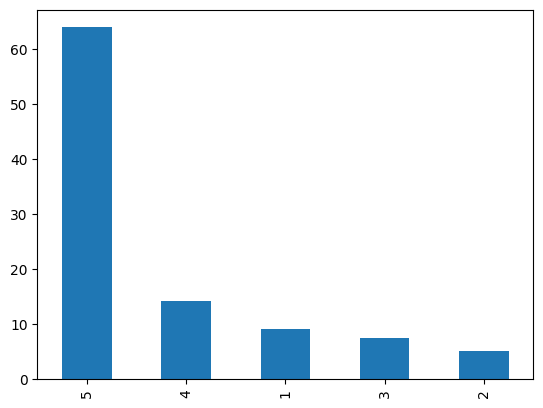

In [ ]:
rating_distribution = df['Score'].value_counts() / len(df) * 100
print(rating_distribution)

rating_distribution.plot.bar()
plt.show()

df = pd.DataFrame(df, columns=['Score', 'Text'])
df.rename(columns={'Score': 'Rating', 'Text': 'Review'}, inplace=True)

# Apply sentiment mapping


In [ ]:
def apply_sentiment(rating):
    if rating <= 2:
        return 0
    elif rating == 3:
        return 1
    else:
        return 2


df['Sentiment'] = df['Rating'].apply(apply_sentiment)
df.drop(['Rating'], axis=1, inplace=True)

sentiment = df['Sentiment'].value_counts()
print(sentiment)
display(df.head())

2    221975
0     40812
1     21421
Name: Sentiment, dtype: int64


,Review,Sentiment
0,When I first opened the canister the smell of ...,0
1,"Item arrived faster than anticipated, which is...",2
2,I CAN'T GET ENOUGH OF THIS DRINK AND IT DOES R...,2
3,Blue Diamond almonds are a huge favorite and I...,2
4,I am the very definition of a beginning matcha...,2


# Tokenize the reviews and truncate/pad to a maximum length


In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
max_length = 128

tokenized_reviews = [
    tokenizer.encode(review, add_special_tokens=True, max_length=max_length, padding='max_length', truncation=True) for
    review in df['Review']]

# Convert the tokenized reviews to PyTorch tensors
input_ids = torch.tensor(tokenized_reviews)

# Print the first 10 tokenized reviews
print(input_ids[:10])

tensor([[  101,  2043,  1045,  ...,  2023,  4031,   102],
        [  101,  8875,  3369,  ...,     0,     0,     0],
        [  101,  1045,  2064,  ...,     0,     0,     0],
        ...,
        [  101,  2026,  3899,  ...,     0,     0,     0],
        [  101,  6919,  4157,  ...,     0,     0,     0],
        [  101, 10166,  1010,  ...,     0,     0,     0]])


Print and decode token IDS for review

In [ ]:
# Decode the token IDs of the first review
decoded_review = tokenizer.decode(input_ids[0])

# Print the original review and the decoded review
print('Original Review:', df['Review'][0])
print('Decoded Review:', decoded_review)

Original Review: When I first opened the canister the smell of pepper was burst forth.  At the first taste, first the salt and then the pepper flavors completely overwhelmed the cashew flavor.  Finally a hint of cashew came through. When  other family members tried these their reactions were similar - too much seasoning and too little cashew.<br /><br />Those who are fans of cashews will  probably be disappointed that there is so little cashew flavor but those who like salt and especially those who like pepper will be pleased.  It just seems to me that there is no need to use cashews in this product, peanuts would do just fine since the salt and pepper flavors completely dominate this product.
Decoded Review: [CLS] when i first opened the canister the smell of pepper was burst forth. at the first taste, first the salt and then the pepper flavors completely overwhelmed the cashew flavor. finally a hint of cashew came through. when other family members tried these their reactions were si

# Save tokenized reviews and decoded reviews into separate files

In [ ]:
# Save the tokenized reviews tensor to a file
torch.save(input_ids, 'tokenized_reviews.pt')

# Open a text file for writing
with open('decoded_reviews.txt', 'w') as f:
    # Iterate through the tokenized reviews, decode them, and write each decoded review to a new line in the file
    for review in input_ids:
        decoded_review = tokenizer.decode(review)
        f.write(decoded_review)
        f.write('\n')

# Conduct train-test split for model

In [ ]:
# Create labels tensor
labels = torch.tensor(df['Sentiment'].values)

# Split data into training and testing sets
train_inputs, test_inputs, train_labels, test_labels = train_test_split(input_ids, labels, random_state=42,
                                                                        test_size=0.1)

# Further prepare for training the model


In [ ]:
# Create DataLoaders for training and testing sets
batch_size = 16
train_data = TensorDataset(train_inputs, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

test_data = TensorDataset(test_inputs, test_labels)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

# Load the BERT model for sequence classification

In [ ]:
# If using without a pre-trained model, then uncomment this
# model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)

In [ ]:
# Load model with pre-trained model
# If using without a trained-model, then comment this out
model = BertForSequenceClassification.from_pretrained('trained_model')

In [ ]:
# Tell model to use CUDA cores if available otherwise use CPU for processing
model = model.to('cuda' if torch.cuda.is_available() else 'cpu')

# Set up the optimizer and the learning rate scheduler


These two lines create an optimizer with a fixed learning rate and a scheduler that adjusts the learning rate based on the validation loss during training. The purpose of the optimizer is to minimize the loss function (cross-entropy in this case) by adjusting the parameters of the model, and the purpose of the scheduler is to improve the convergence of the optimization algorithm and prevent overfitting.


In [ ]:
# Set up the optimizer and the learning rate scheduler
optimizer = Adam(model.parameters(), lr=2e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=1, factor=0.5, verbose=True)

# Set up the training loop for the model
- Commented out since we're using pre-trained model

In [ ]:
# Set up the training loop
# num_epochs = 5
# training_losses = []
# testing_losses = []

# Train the model for num_epochs epochs
for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")

    # Set the model to training mode
    model.train()
    train_loss = 0
    
    # Iterate over the training data in batches
    for batch in train_dataloader:
        # Move the batch to the device (CPU or GPU)
        batch = tuple(t.to('cuda' if torch.cuda.is_available() else 'cpu') for t in batch)
        inputs, labels = batch
        
        # Zero the gradients
        optimizer.zero_grad()
        
        # Forward pass through the model
        outputs = model(inputs, labels=labels)
        loss = outputs.loss
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
        # Accumulate the training loss
        train_loss += loss.item()

    # Calculate the average training loss for the epoch
    avg_train_loss = train_loss / len(train_dataloader)
    
    # Append the training loss to the list of losses
    training_losses.append(avg_train_loss)
    
    # Print the average training loss
    print(f"Training loss: {avg_train_loss}")

    # Set the model to evaluation mode
    model.eval()
    test_loss = 0
    
    # Iterate over the testing data in batches
    for batch in test_dataloader:
        # Move the batch to the device (CPU or GPU)
        batch = tuple(t.to('cuda' if torch.cuda.is_available() else 'cpu') for t in batch)
        inputs, labels = batch
        
        # Disable gradient calculations
        with torch.no_grad():
            # Forward pass through the model
            outputs = model(inputs, labels=labels)
            loss = outputs.loss
        
        # Accumulate the testing loss
        test_loss += loss.item()

    # Calculate the average testing loss for the epoch
    avg_test_loss = test_loss / len(test_dataloader)
    
    # Append the testing loss to the list of losses
    testing_losses.append(avg_test_loss)
    
    # Print the average testing loss
    print(f"Testing loss: {avg_test_loss}")

    # Update the learning rate using the scheduler
    scheduler.step(avg_test_loss)


# Save model, training and test loss into separate files
- Commented out since we're using the pre-trained model

In [ ]:
# # Save the trained model
# model.save_pretrained('trained_model')

# Save the training and testing loss values
# with open("loss_values.json", "w") as f:
#     json.dump({"train_loss": training_losses, "test_loss": testing_losses}, f)

# Load saved loss values for visualization

In [ ]:
# Load the saved loss values
with open("loss_values.json", "r") as f:
    loss_data = json.load(f)

training_losses = loss_data["train_loss"]
testing_losses = loss_data["test_loss"]

# Visualize training loss and testing loss

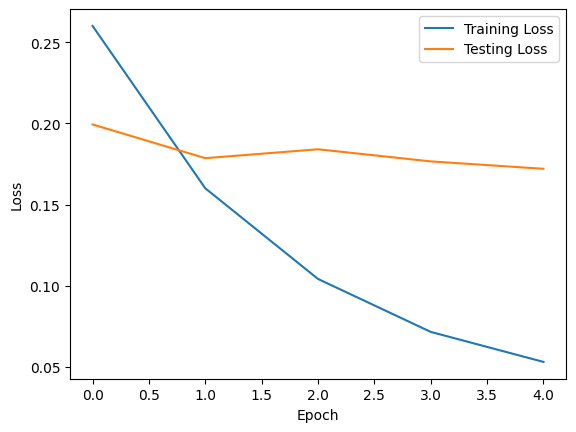

In [ ]:
# Plot training and testing losses
plt.plot(training_losses, label="Training Loss")
plt.plot(testing_losses, label="Testing Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Conduct predictions on a test set for further evaluation

In [ ]:
# Make predictions on the test set
# Set the model to evaluation mode
model.eval()

# Create lists to store the predicted labels and true labels
predictions = []
true_labels = []

# Iterate over the testing data in batches
for batch in test_dataloader:
    # Move the batch to the device (CPU or GPU)
    batch = tuple(t.to('cuda' if torch.cuda.is_available() else 'cpu') for t in batch)
    inputs, labels = batch
    
    # Disable gradient calculations
    with torch.no_grad():
        # Forward pass through the model
        outputs = model(inputs)
        logits = outputs.logits

    # Detach the logits from the computation graph and move to the CPU
    logits = logits.detach().cpu().numpy()
    # Move the label ids to the CPU and convert to a numpy array
    label_ids = labels.to('cpu').numpy()

    # Get the predicted labels by taking the argmax of the logits
    predictions.extend(np.argmax(logits, axis=1))
    # Add the true labels to the list of true labels
    true_labels.extend(label_ids)


# Print out the classification report

In [ ]:
# Compute the classification report and print it
print("\nClassification Report:")
print(classification_report(true_labels, predictions))


Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.90      0.90      4021
           1       0.77      0.72      0.74      2150
           2       0.97      0.98      0.98     22250

    accuracy                           0.95     28421
   macro avg       0.88      0.86      0.87     28421
weighted avg       0.95      0.95      0.95     28421



# Visualize the confusion matrix

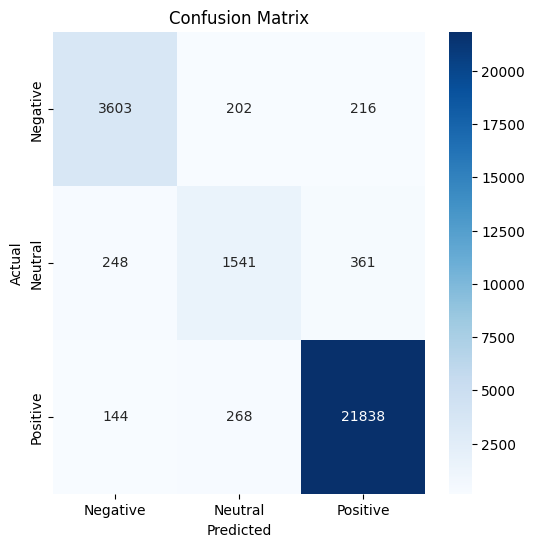

In [ ]:
# Compute the confusion matrix and plot it as a heatmap
confusion_mtx = confusion_matrix(true_labels, predictions)
plt.figure(figsize=(6, 6))
sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='Blues', cbar=True,
            xticklabels=['Negative', 'Neutral', 'Positive'], yticklabels=['Negative', 'Neutral', 'Positive'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Print out the accuracy score

In [ ]:
# Calculate and print the accuracy score
accuracy = np.mean(np.array(true_labels) == np.array(predictions))
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.9494


# Prepare sample input for testing evaluation

In [ ]:
# Define the sample messages
sample_messages = [
    "I hate this product! I gave it to all of my enemies!",
    "I love this product! I gave it to all of my friends!",
    "Meh. That's all I can say",
    "I could not pay my friends enough to take it off my hands. I haven't heard from them since. My social life is in shambles",
    "This product is amazing! It exceeded my expectations and has become an essential part of my daily routine.",
    "This is hands down the best purchase I've made in a long time. The product is incredibly easy to use.",
    "The product is decent, but I don't think it's anything special. It does what it's supposed to do, but it's not as good as some of the other options out there.",
    "The item arrived on time and was as described, but it didn't really live up to the hype. It's just okay - not terrible, but not great either.",
    "I had high hopes for this product, but it turned out to be a total waste of money. It's flimsy, doesn't perform well",
    "I'm extremely disappointed with this product. It broke after just a few uses, and the quality is nowhere near what I expected"
]

# Tokenize the sample input for evaluation


In [ ]:
# Tokenize the sample messages
sample_tokenized = [
    tokenizer.encode(message, add_special_tokens=True, max_length=max_length, padding='max_length', truncation=True)
    for message in sample_messages
]

# Convert the tokenized messages to PyTorch tensors
sample_input_ids = torch.tensor(sample_tokenized)

# Create a DataLoader for the sample messages
sample_data = TensorDataset(sample_input_ids)
sample_dataloader = DataLoader(sample_data, batch_size=batch_size)

# Finally evaluate the sample messages through the model

In [ ]:
# Make predictions for the sample messages
# Set the model to evaluation mode
model.eval()

# Create a list to store the predicted labels for the sample data
sample_predictions = []

# Iterate over the sample data in batches
for inputs in sample_dataloader:
    # Move the input batch to the device (CPU or GPU)
    inputs = inputs[0].to('cuda' if torch.cuda.is_available() else 'cpu')
    
    # Disable gradient calculations
    with torch.no_grad():
        # Forward pass through the model
        outputs = model(inputs)
        logits = outputs.logits

    # Calculate the probabilities of each class using the softmax function
    probs = torch.softmax(logits, dim=1)
    
    # Get the confidence scores and predicted labels by taking the argmax of the probabilities
    confidences, predicted_labels = torch.max(probs, dim=1)
    
    # Detach the confidence scores and predicted labels from the computation graph and move to the CPU as numpy arrays
    confidences = confidences.detach().cpu().numpy()
    predicted_labels = predicted_labels.detach().cpu().numpy()
    
    # Add the predicted labels to the list of sample predictions
    sample_predictions.extend(predicted_labels)


# Print out sample messages with their sentiment predictions and confidence score

In [ ]:
# Print the sample messages and their predictions and confidences
sentiment_mapping = {0: "Negative", 1: "Neutral", 2: "Positive"}
for message, prediction, confidence in zip(sample_messages, sample_predictions, confidences):
    print(f"Message: {message}\nPrediction: {sentiment_mapping[prediction]}, Confidence: {confidence:.4f}\n")

Message: I hate this product! I gave it to all of my enemies!
Prediction: Negative, Confidence: 0.9538

Message: I love this product! I gave it to all of my friends!
Prediction: Positive, Confidence: 0.9997

Message: Meh. That's all I can say
Prediction: Neutral, Confidence: 0.5535

Message: I could not pay my friends enough to take it off my hands. I haven't heard from them since. My social life is in shambles
Prediction: Positive, Confidence: 0.9869

Message: This product is amazing! It exceeded my expectations and has become an essential part of my daily routine.
Prediction: Positive, Confidence: 0.9998

Message: This is hands down the best purchase I've made in a long time. The product is incredibly easy to use.
Prediction: Positive, Confidence: 0.9998

Message: The product is decent, but I don't think it's anything special. It does what it's supposed to do, but it's not as good as some of the other options out there.
Prediction: Neutral, Confidence: 0.9976

Message: The item arriv